Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
A tisztított adatmentés elkészült: /content/drive/MyDrive/Colab Notebooks/output/netflix_cleaned.csv


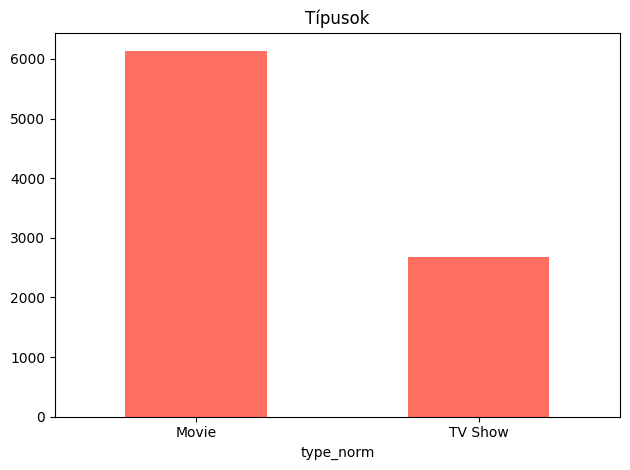

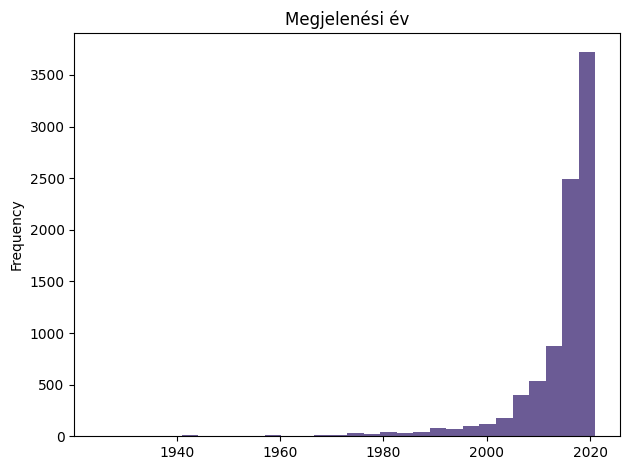

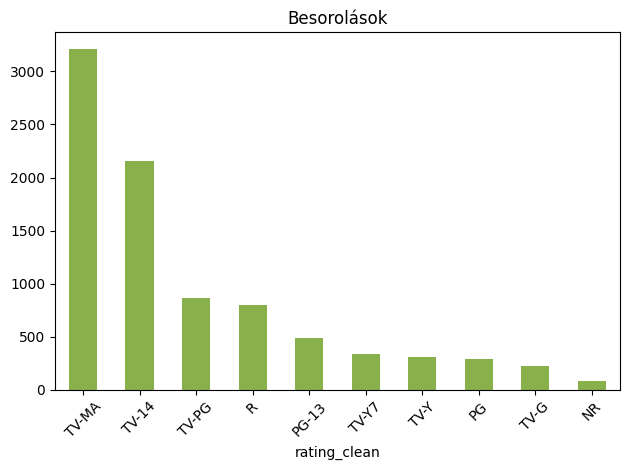

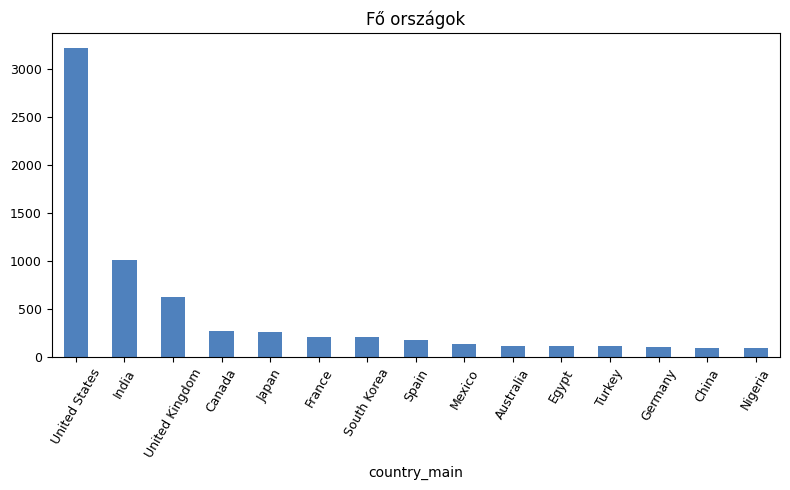

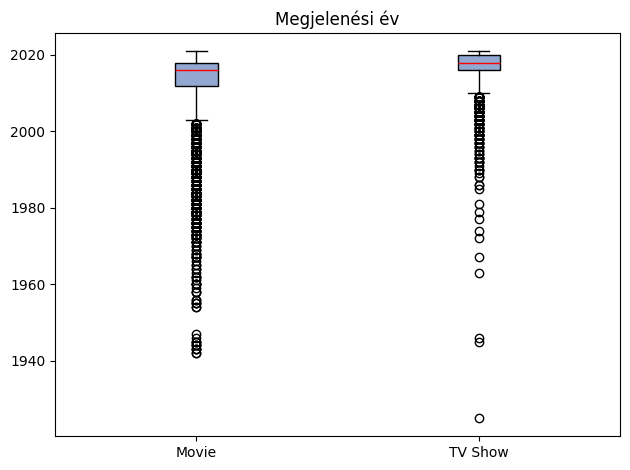

Mann–Whitney U statisztika: 5820528.00 | p-érték: 2.051e-105
Filmek medián éve: 2016, Sorozatok medián éve: 2018


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(



=== Modell eredmények ===
Pontosság: 0.998, ROC-AUC: 1.000
              precision    recall  f1-score   support

           0      0.998     0.999     0.999      1533
           1      0.999     0.996     0.997       669

    accuracy                          0.998      2202
   macro avg      0.998     0.997     0.998      2202
weighted avg      0.998     0.998     0.998      2202



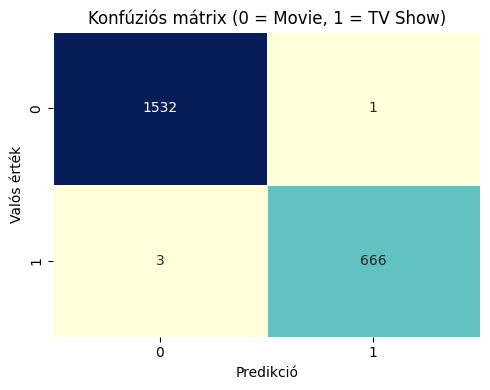

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

# --- Elérési utak ---
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks"
PATH = os.path.join(BASE_DIR, "netflix_titles.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

os.makedirs(OUTPUT_DIR, exist_ok=True)


# --- Segédfüggvények ---
def parse_duration_minutes(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'(\d+)\s*min', str(x))
    return float(m.group(1)) if m else np.nan


def parse_seasons(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'(\d+)\s*Season', str(x), re.IGNORECASE)
    return float(m.group(1)) if m else np.nan


def count_persons(x):
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "" or x.strip().lower() == "nan":
        return 0
    return len([p for p in [i.strip() for i in x.split(",")] if p])


def first_country(x):
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "" or x.strip().lower() == "nan":
        return np.nan
    return x.split(",")[0].strip()


def clean_rating(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().upper()
    mapping = {
        "UR": "NR",
        "TV MA": "TV-MA",
        "TV 14": "TV-14",
        "TV PG": "TV-PG",
        "TV Y7": "TV-Y7",
        "TV Y": "TV-Y"
    }
    return mapping.get(x, x)


def split_genres(x):
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "" or x.strip().lower() == "nan":
        return []
    return [g.strip() for g in x.split(",")]


def main():
    # 1) Adattisztítás
    df = pd.read_csv(PATH)
    df.columns = [c.strip() for c in df.columns]
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip().replace({"nan": np.nan})

    if 'date_added' in df.columns:
        df['date_added_parsed'] = pd.to_datetime(df['date_added'], errors='coerce')

    df['type_norm'] = df['type'].apply(
        lambda x: 'TV Show' if isinstance(x, str) and re.search(r'tv\s*show', x, flags=re.I)
        else ('Movie' if isinstance(x, str) and re.search(r'movie', x, flags=re.I) else np.nan)
    )

    df['duration_minutes'] = df['duration'].apply(parse_duration_minutes)
    df['seasons'] = df['duration'].apply(parse_seasons)
    df['cast_count'] = df['cast'].apply(count_persons) if 'cast' in df.columns else 0
    df['country_main'] = df['country'].apply(first_country) if 'country' in df.columns else np.nan
    df['rating_clean'] = df['rating'].apply(clean_rating) if 'rating' in df.columns else np.nan
    df['genre_list'] = df['listed_in'].apply(split_genres) if 'listed_in' in df.columns else [[]]

    from collections import Counter
    genre_counter = Counter()
    for gs in df['genre_list']:
        genre_counter.update(gs)
    top_genres = [g for g, _ in genre_counter.most_common(20)]
    for g in top_genres:
        df[f'genre_{g}'] = df['genre_list'].apply(lambda lst: 1 if g in lst else 0).astype(float)

    output_csv = os.path.join(OUTPUT_DIR, "netflix_cleaned.csv")
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"A tisztított adatmentés elkészült: {output_csv}")

    # 2) Feltáró ábrák
    plt.figure()
    df['type_norm'].value_counts(dropna=False).plot(kind='bar', rot=0, color='#FF6F61')
    plt.title("Típusok")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plot_type_counts.png"))
    plt.show()
    plt.close()

    plt.figure()
    df['release_year'].dropna().astype(int).plot(kind='hist', bins=30, color='#6B5B95')
    plt.title("Megjelenési év")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plot_release_year_hist.png"))
    plt.show()
    plt.close()

    plt.figure()
    df['rating_clean'].value_counts().head(10).plot(kind='bar', rot=45, color='#88B04B')
    plt.title("Besorolások")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plot_rating_top10.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(8,5))
    df['country_main'].value_counts().head(15).plot(
        kind='bar',
        color='#4F81BD',
        rot=60,
        fontsize=9
    )
    plt.title("Fő országok")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plot_country_top15.png"))
    plt.show()
    plt.close()

    tmp = df[['type_norm', 'release_year']].dropna().copy()
    tmp['release_year'] = tmp['release_year'].astype(float)
    data_movie = tmp.loc[tmp['type_norm'] == 'Movie', 'release_year'].values
    data_tv = tmp.loc[tmp['type_norm'] == 'TV Show', 'release_year'].values

    plt.figure()
    plt.boxplot([data_movie, data_tv], tick_labels=['Movie', 'TV Show'],
                patch_artist=True,
                boxprops=dict(facecolor='#92A8D1', color='black'),
                medianprops=dict(color='red'))
    plt.title("Megjelenési év")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plot_year_box_by_type.png"))
    plt.show()
    plt.close()

    # 3) Hipotézisvizsgálat
    movies_year = df.loc[df['type_norm'] == 'Movie', 'release_year'].dropna().astype(int)
    tv_year = df.loc[df['type_norm'] == 'TV Show', 'release_year'].dropna().astype(int)
    mw_stat, mw_p = mannwhitneyu(movies_year, tv_year, alternative='two-sided')
    print(f"Mann–Whitney U statisztika: {mw_stat:.2f} | p-érték: {mw_p:.3e}")
    print(f"Filmek medián éve: {np.median(movies_year):.0f}, Sorozatok medián éve: {np.median(tv_year):.0f}")

    # 4) Osztályozás
    df_model = df[df['type_norm'].isin(['Movie', 'TV Show'])].copy()
    y = (df_model['type_norm'] == 'TV Show').astype(int)

    numeric_features = ['release_year', 'duration_minutes', 'seasons', 'cast_count']
    categorical_features = ['rating_clean', 'country_main']
    genre_features = [c for c in df_model.columns if c.startswith('genre_')]

    for col in numeric_features + genre_features:
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

    X = df_model[numeric_features + categorical_features + genre_features].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    genre_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('gen', genre_transformer, genre_features)
        ],
        remainder='drop'
    )

    clf = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', LogisticRegression(max_iter=400))
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print("\n=== Modell eredmények ===")
    print(f"Pontosság: {acc:.3f}, ROC-AUC: {roc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='YlGnBu',
        linewidths=0.5,
        linecolor='white',
        cbar=False
    )
    plt.title("Konfúziós mátrix (0 = Movie, 1 = TV Show)")
    plt.xlabel("Predikció")
    plt.ylabel("Valós érték")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plot_confusion_matrix.png"))
    plt.show()
    plt.close()


if __name__ == "__main__":
    main()
